In [1]:
import utils
import metrics
import CNNLSTMModel

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

LUCKY_NUMBER = 2
TARGET_SIZE = (64, 64) # For no compression choose -1
TARGET_SLICES = 304

In [2]:
print("GPUs Available: ",tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

GPUs Available:  []


Prepare data

In [ ]:
photos_path = "E:\\images\\"
masks_path = "E:\\masks\\"

scan_names = [file[:8] for file in os.listdir(photos_path) if file.endswith(".nii.gz")]
train, val, test = utils.split_train_val_test(scan_names, 0.7, 0.15, 0.15)
train = train[:5]
print(f"Training data size: {len(train)}, Validation data size: {len(val)}, Test data size: {len(test)}")

train_gen = utils.cbct_data_generator(photos_path, masks_path, train)
val_gen = utils.cbct_data_generator(photos_path, masks_path, val)

epochs = 6
model = CNNLSTMModel.create_cnn_lstm_model(image_shape=TARGET_SIZE, num_slices=TARGET_SLICES)
model.summary()

Training data size: 5, Validation data size: 21, Test data size: 21


Model: "CNN_LSTM_Segmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 64, 64, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 32768)      │        92,672 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 128)        │    16,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 50, 4096)       │       266,240 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 64, 64, 1)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,251,584 (65.81 MB)

 Trainable params: 17,251,584 (65.81 MB)

 Non-trainable params: 0 (0.00 B)

Train model

In [5]:
model.fit(
    train_gen, 
    steps_per_epoch=len(train),
    #validation_data=val_gen,
    #validation_steps=len(val),
    epochs=epochs)

#utils.save_model(model)

ZEBY_207_0000.nii.gz: (1, 50, 64, 64, 1), ZEBY_207.nii.gz: (1, 50, 64, 64, 1)
ZEBY_220_0000.nii.gz: (1, 50, 64, 64, 1), ZEBY_220.nii.gz: (1, 50, 64, 64, 1)
Epoch 1/6
2/5 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - binary_io_u: 0.0185 - dice: 0.9680 - loss: 0.9680  ZEBY_215_0000.nii.gz: (1, 50, 64, 64, 1), ZEBY_215.nii.gz: (1, 50, 64, 64, 1)
3/5 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - binary_io_u: 0.0195 - dice: 0.9669 - loss: 0.9669ZEBY_240_0000.nii.gz: (1, 50, 64, 64, 1), ZEBY_240.nii.gz: (1, 50, 64, 64, 1)
4/5 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - binary_io_u: 0.0190 - dice: 0.9679 - loss: 0.9679ZEBY_182_0000.nii.gz: (1, 50, 64, 64, 1), ZEBY_182.nii.gz: (1, 50, 64, 64, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - binary_io_u: 0.0179 - dice: 0.9704 - loss: 0.9704
Epoch 2/6
ZEBY_207_0000.nii.gz: (1, 50, 64, 64, 1), ZEBY_207.nii.gz: (1, 50, 64, 64, 1)
1/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - binary_io_u: 0.0265 - dice: 0.9705 - loss: 0.9705ZEBY_220_0000.nii.gz: (1, 50, 64, 64, 1), ZEBY_220.nii.gz: (1, 50, 64, 6

Make prediction

In [25]:
test_scan = utils.load_nifti_cbct_scan(photos_path+train[1]+"_0000.nii.gz")
test_scan = test_scan[..., np.newaxis]
test_scan = np.expand_dims(test_scan, axis=0)

predictions = model.predict(test_scan)

predicted_mask = predictions[0]
print(type(predicted_mask[0,0,0,0]))

binary_mask = (predicted_mask > 0.5).astype(np.float32)
print(type(binary_mask[0,0,0,0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
<class 'numpy.float32'>
<class 'numpy.float32'>


Plot results

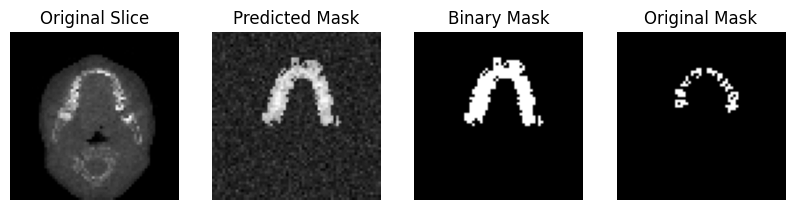

In [28]:
slice_index = 20

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.title("Original Slice")
plt.imshow(test_scan[0, slice_index, :, :, 0], cmap="gray")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask[slice_index, :, :, 0], cmap="gray")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Binary Mask")
plt.imshow(binary_mask[slice_index, :, :, 0], cmap="gray")
plt.axis('off')

original_mask = utils.load_nifti_mask(masks_path+test[1]+".nii.gz")
plt.subplot(1, 4, 4)
plt.title("Original Mask")
plt.imshow(original_mask[slice_index,:,:], cmap="gray")
plt.axis('off')
plt.show()